# C++ Convolution

![raw](./imgs/pagani.jpg)

This note shows:
1. C++ code from Python
2. Convolution in C++
3. C++ Convolution from Python

## C/C++ from Python

The easy part:  
To create a C/C++ function from a library file, you add 'extern "C"' to the function header.  
The difficult part:  
Passing parameters and returning values.

In [1]:
# http://localhost:8888/notebooks/1_Image_Metadata.ipynb
from AI_Decomposed import image_meta 
from AI_Decomposed import display_channel

# http://localhost:8888/notebooks/2_Py_Convolution.ipynb
from AI_Decomposed import PY_recurse_pooling

## grab image

In [2]:
from PIL import Image
image_file = './imgs/pagani.jpg'
[height, width, red,green,blue] = image_meta(image_file)
channel_size = height * width

print('image height  : ', height)
print('image width   : ', width)
print('chanel size   : ', channel_size)
print('total pixels  : ', channel_size * 3) # 3 channels

image height  :  521
image width   :  750
chanel size   :  390750
total pixels  :  1172250


### green channel

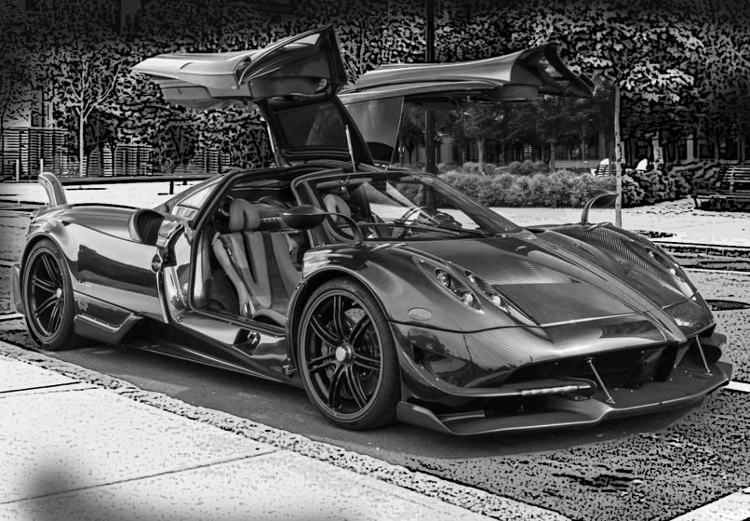

390750

In [3]:
green_image = Image.new('L', (width, height))
green_image.putdata(green)
display(green_image)
len(green)

## C++ code - apply pooling, and resurse pooling

This code is a port of the Python code from the preceding notebook.  
http://localhost:8888/notebooks/2_Py_Convolution.ipynb  
In the previous notebook, the Python version of this code took **216.143** seconds, to recurse **100** times while performing <i>mean</i> pooling.

![cpp](./imgs/cpp.png)

## Calling above C++ code from Python takes some wrangling

In [4]:
import ctypes
from ctypes import *
import numpy as np

# create reference to C++ fucntion
cpp_function_ptr = cdll.LoadLibrary('./cpp/cmake-build-debug/libconvolution.so').recurse_convolution

def native_recurse_pooling(mat, width, recurse_cnt, use_max, function_ptr):    
    height = (int)(len(mat) / width)
    # create pointer array
    ptr_param = pointer((ctypes.c_int * len(mat))(*mat))

    # calculate array size after function call
    returned_height = height - recurse_cnt
    returned_width  = width - recurse_cnt
    returned_convolution_array_size = returned_height * returned_width
    # define return type of integer pointer array
    function_ptr.restype = ctypes.POINTER(ctypes.c_int * (returned_convolution_array_size))
    # conver boolean to int
    f=0
    if use_max:
       f=1 
    # actuall call to C++ code
    ptr_array_convolution = function_ptr(ptr_param, width, height, recurse_cnt, f)
    # convert int pointer array to Python list
    ret_convo = np.ctypeslib.as_array( ptr_array_convolution.contents ,shape=(1,)).astype(int).tolist()
    # return Python list of convolution pixels
    return ret_convo

## Call C++ pooling function

In [5]:
recurse_cnt = 1
mat = green 

convolution = native_recurse_pooling(mat, width, recurse_cnt, True, cpp_function_ptr)

## visualize convolution

389480

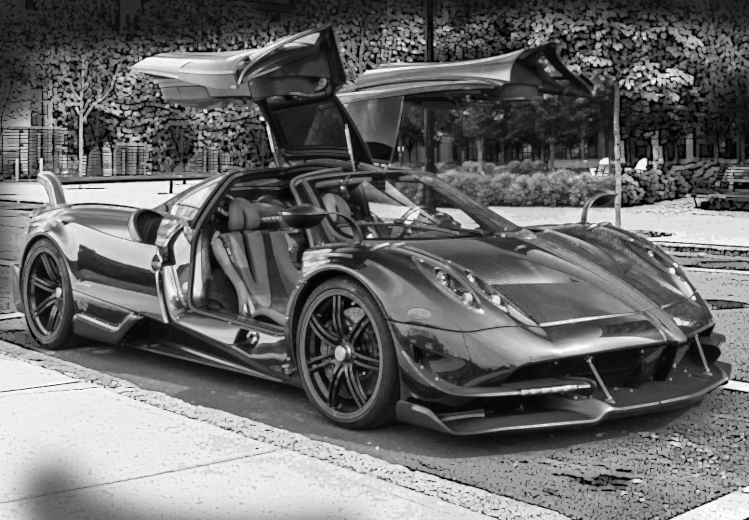

In [6]:
display(len(convolution))
display_channel(convolution, width - (recurse_cnt))

## another example, reduce by 10, use mean pooling

In [7]:
recurse_cnt = 10
convolution = native_recurse_pooling(mat, width, recurse_cnt, False, cpp_function_ptr)

## visualize convolution

378140

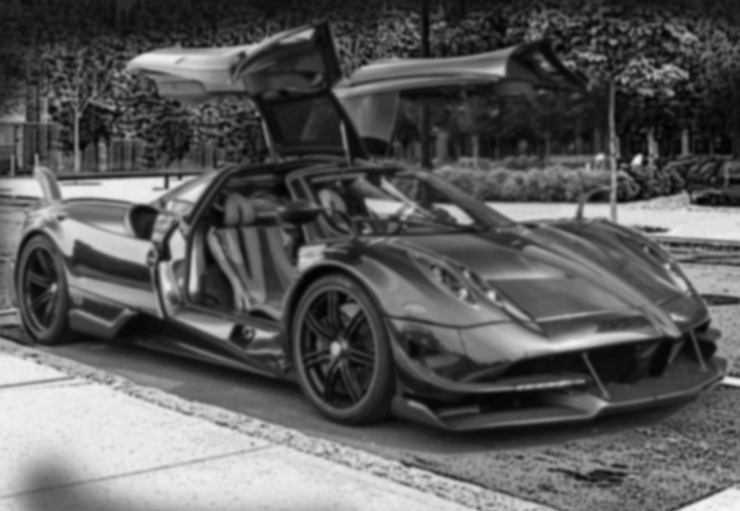

In [8]:
display(len(convolution))
display_channel(convolution, width - (recurse_cnt))

# NEXT  -  Python vs C++ performance

http://localhost:8888/notebooks/4_Compare_Performance_Python_VS_C%2B%2B.ipynb

![raw](./imgs/lambo.jpg)